## Census Block Group to ZCTA crossmapping operation

Certain datasets are captured at highly granular resolution. In those cases, the data may need additional features to ask questions at a broader geographic scale though smaller than State scale.

In this exercise, we will need to create a table that crossmaps between the US Census Block Group ID and geometry with the US Zip Code Tabulation Area (ZCTA) ID and geometry.

The source data will be obtained from these steps:
1) Go to the US Census website: https://www.census.gov/data/data-tools.html
2) Click on the "Explore data" menu, then choose "Data Tools and Apps"
3) Click on "Explore Census Data"; it will take you to https://data.census.gov/cedsci/
4) Search for "ZCTA shapefile
5) In the 'Geographic Products available for ZCTAs' area, click on "TIGER/Line Shapefiles"
    - https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
6) Click on "FTP Archive" under the Download section
    - It will take you here: https://www2.census.gov/geo/tiger/TIGER2019/

7) Click on "ZCTA5/"
8) Download and unzip the "tl_2019_us_zcta510.zip"

9) Go back and click on "BG/"
10) Download and unzip the Block group shapefile for your place of interest. The number system corresponds to the State ID.
    - For example, download "tl_2019_72_bg.zip"


In [1]:
import geopandas as gpd
import pandas as pd
import os
%matplotlib inline

In [79]:
%%time
# read in the zcta dataset
#zctap = gpd.read_file(os.path.join(os.getcwd(),'zcta510p/zcta510p.shp'))
#zcta_wa = gpd.read_file(os.path.join(os.getcwd(),'zcta510/zcta510.shp'))

zcta = gpd.read_file(os.path.join(os.getcwd(),'tl_2019_us_zcta510/tl_2019_us_zcta510.shp'))
print(zcta.shape)
zcta.head()

CPU times: user 20.3 s, sys: 1.69 s, total: 22 s
Wall time: 23.2 s


((33144, 10),
   ZCTA5CE10 GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  AWATER10  \
 0     43451   43451        B5   G6350          S   63484186    157689   
 1     43452   43452        B5   G6350          S  121522304  13721730   
 2     43456   43456        B5   G6350          S    9320975   1003775   
 3     43457   43457        B5   G6350          S   48004681         0   
 4     43458   43458        B5   G6350          S    2573816     39915   
 
     INTPTLAT10    INTPTLON10  \
 0  +41.3183010  -083.6174935   
 1  +41.5157923  -082.9809454   
 2  +41.6318300  -082.8393923   
 3  +41.2673301  -083.4274872   
 4  +41.5304461  -083.2133648   
 
                                             geometry  
 0  POLYGON ((-83.708733 41.327326, -83.708147 41....  
 1  POLYGON ((-83.086978 41.537796, -83.0825629999...  
 2  (POLYGON ((-82.835577 41.710823, -82.83515 41....  
 3  POLYGON ((-83.49650299999999 41.253708, -83.48...  
 4  POLYGON ((-83.222292 41.531025, -83.2222819999...  )

## Try this for the American Samoa territory

In [89]:
%%time
bg60 = gpd.read_file(os.path.join(os.getcwd(),'tl_2019_60_bg/tl_2019_60_bg.shp'))
print(bg60.shape)
bg60.head()

(43, 13)
CPU times: user 14.9 ms, sys: 1.72 ms, total: 16.6 ms
Wall time: 18.5 ms


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,60,010,950100,1,600109501001,Block Group 1,G5030,S,6464464,62541435,-14.2348405,-170.6709625,"POLYGON ((-170.70392 -14.203366, -170.702795 -..."
1,60,010,950100,2,600109501002,Block Group 2,G5030,S,5407957,93320495,-14.2587411,-170.5618796,"POLYGON ((-170.59622 -14.270741, -170.594773 -..."
2,60,010,950200,1,600109502001,Block Group 1,G5030,S,2663476,7577980,-14.2859572,-170.5589852,"POLYGON ((-170.581535 -14.264811, -170.580143 ..."
3,60,010,950300,3,600109503003,Block Group 3,G5030,S,6625648,26472670,-14.2814787,-170.6316567,"POLYGON ((-170.654247 -14.272489, -170.653858 ..."
4,60,010,950500,1,600109505001,Block Group 1,G5030,S,1210356,1565784,-14.2682603,-170.6756495,"POLYGON ((-170.689785 -14.264842, -170.689646 ..."


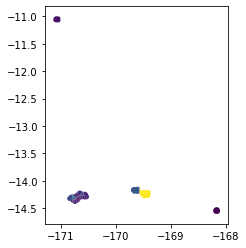

In [81]:
bg60.plot('ALAND')

In [95]:
# confirm projections
print(zcta.crs)
print(bg60.crs)

# default dimensions
print(bg60.shape)

{'init': 'epsg:4269'}
{'init': 'epsg:4269'}
(43, 13)


In [83]:
# identify bg that fit within ZCTAs
bg_within = gpd.sjoin(bg60, zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']], how='inner', op='within')
bg_within.shape

(10, 16)

In [85]:
# identify bg that have more than 1 ZCTA mapping
bg_within.loc[bg_within.GEOID.isin(bg_within.groupby('GEOID')['ZCTA5CE10'].count()>1)]

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,index_right,GEOID10,ZCTA5CE10


In [84]:
# identify bg that fit within ZCTA or have boundary intersections
bg_intersects = gpd.sjoin(bg60, zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']], how='inner', op='intersects')
bg_intersects.shape

(42, 16)

In [86]:
# identify bg that have more than 1 ZCTA mapping
bg_intersects.loc[bg_intersects.GEOID.isin(bg_intersects.groupby('GEOID')['ZCTA5CE10'].count()>1)]

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,index_right,GEOID10,ZCTA5CE10


In [90]:
# identify bg that did not join with ZCTAs
bg60.loc[~bg60.GEOID.isin(bg_intersects['GEOID'])]

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
23,60,030,951900,1,600309519001,Block Group 1,G5030,S,82093,147383994,-14.5365298,-168.1512918,"POLYGON ((-168.225273 -14.535906, -168.224529 ..."


## Try this for Washington state

In [386]:
import urllib as urllib2
import wget
import bz2
import zipfile
#import shutil

In [387]:
def getStateCBG(domain='https://www2.census.gov/geo/tiger/TIGER2019/BG',
                fname='tl_2019_{0}_bg'.format('53')):

    # generate source and local filepath
    filename = fname+'.zip'
    fileurl = os.path.join(domain, filename)

    # download zipfile
    ping = urllib2.request.urlopen(os.path.join(domain, output))
    if ping.getcode() != 404:
        wget.download(fileurl)

    # generate the destination folder
    if os.path.exists(os.path.join(os.getcwd(),fname)):
        pass
    else:
        os.mkdir(os.path.join(os.getcwd(),fname))

    # extract to destination folder
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(os.getcwd(),fname))

    # remove zip file
    os.remove(filename)
    return(os.path.join(os.getcwd(),fname, fname+'.shp'))

In [492]:
def crossmap_BG_to_ZCTA(poly_bg,
                        poly_zcta,
                        outshapefilepath,
                        uid='GEOID',
                        zip_code_fieldname='ZCTA5CE10'):
    
    """
    poly_bg (geodataframe): geodataframe of the Census Block group file
    poly_zcta (geodataframe): geodataframe of the ZCTA polygon file
    outshapefilepath (dir): the output diretory and name for the shapefile; will also be used for the csv output
    uid (str): GEOID or an equivalent to recognize unique shapes
    zip_code_fieldname (str): ZCTA5CE10 or equivalent to recognize ZIP Codes or ZCTA spatial units
    
    return: 1) mappings as a shapefile and 2) mappings as a csv table
    """
    
    """
    1) identify BGs with geometry that fit within ZCTAs
    """
    poly_bg['centroid'] = bg.centroid
    bg_within = gpd.sjoin(poly_bg, poly_zcta, how='inner', op='within').drop('index_right', axis=1)
    bg_within['overlay'] = 'geometry within ZCTA'

    """
    2) identify BGs that intersect by polygon centroid
    """
    # extract block groups that could not be joined with within method
    bg2 = bg.loc[~bg.index.isin(bg_within.index),:]
    bg_intersects = gpd.sjoin(bg2.set_geometry('centroid'), poly_zcta, 
                              how='inner', op='within').drop('index_right', axis=1)
    bg_intersects['overlay'] = 'centroid intersects ZCTA'

    """
    3) identify BGs that intersect with one zcta by polygon geometry
    """
    # extract block groups that could not be joined with centroid intersection method
    bg3 = bg2.loc[~bg2.index.isin(bg_intersects.index),:]
    bg_g_left = gpd.sjoin(bg3, poly_zcta, how='left', op='intersects').drop('index_right', axis=1)
    mappings = bg_g_left.groupby(uid)[zip_code_fieldname].nunique()
    bg_g_left1 = bg_g_left.loc[bg_g_left.GEOID.isin(mappings[mappings==1].index)]
    bg_g_left1['overlay'] = 'geometry intersects a single ZCTA'

    """
    4) identify BGs with multiple ZCTA by geometry intersection, but 0 ZCTA by centroid intersection
    """
    bg_c_left = gpd.sjoin(bg3.set_geometry('centroid'), poly_zcta,
                          how='left', op='intersects').drop('index_right', axis=1)
    bg_c_left1 = bg_c_left.loc[bg_c_left.loc[:,uid].isin(mappings[mappings>1].index).index]
    bg_c_left1['overlay'] = 'geometry intersects multiple ZCTA, centroid intersects 0 ZCTA'

    """
    5) merge the spatial joins, report, then export
    """
    bg_mapped = pd.concat([bg_within, bg_intersects, bg_g_left1, bg_c_left1])

    # coverage
    print('geometry within: {0}'.format(bg_within.shape[0]/bg.shape[0]))
    print('centroid within: {0}'.format(bg_intersects.shape[0]/bg.shape[0]))
    print('geometry intersects 1 ZCTA: {0}'.format(bg_g_left1.shape[0]/bg.shape[0]))
    print('geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: {0}'.format(bg_c_left1.shape[0]/bg.shape[0]))
    print('total coverage: {0}'.format(bg_mapped[uid].isin(bg[uid]).sum()/bg[uid].nunique()))

    # create directory if not exist
    if not os.path.exists(os.path.abspath(os.path.dirname(outshapefilepath))):
        os.mkdir(os.path.abspath(os.path.dirname(outshapefilepath)))
        
    # export to shapefiles
    bg_mapped.drop('centroid', axis=1).to_file(outshapefilepath)

    # export to dataframe
    bg_mapped.drop(['geometry','centroid'], axis=1)\
        .to_csv(outshapefilepath.replace('.shp','.csv'), header=True, index=False)
    return(bg_mapped)

In [468]:
WA_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('53')) #Washington
TX_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('48')) #Texas
NY_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('36')) #New York
NJ_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('34')) #New Jersey
NH_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('33')) #New Hampshire
MD_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('24')) #Maryland
CT_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('09')) #Conneticut
CA_cbg = getStateCBG(fname = 'tl_2019_{0}_bg'.format('06')) #California

In [493]:
%%time
# California
bg = gpd.read_file(CA_cbg)
CA_bg_mapped = crossmap_BG_to_ZCTA(poly_bg = bg,
                                   poly_zcta = zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']],
                                   outshapefilepath=os.path.join(os.getcwd(),'cbg_zcta_crossmap','CA_cbg.shp'),
                                   uid=['GEOID'],
                                   zip_code_fieldname=['ZCTA5CE10'])

geometry within: 0.7811476822333275
centroid within: 0.21006376012407377
geometry intersects 1 ZCTA: 0.0426503532655523
geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: 0.008788557642598656
total coverage: GEOID    1.04265
dtype: float64
CPU times: user 1min 9s, sys: 2.76 s, total: 1min 12s
Wall time: 1min 13s


In [388]:
%%time
# WA
bg = gpd.read_file(WA_cbg)
print(bg.shape)
bg.head()

(4783, 14)
CPU times: user 966 ms, sys: 123 ms, total: 1.09 s
Wall time: 1.19 s


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid
0,53,029,971400,2,530299714002,Block Group 2,G5030,S,2814636,1797525,+48.2062765,-122.5296535,"POLYGON ((-122.54657 48.208011, -122.542498 48...",POINT (-122.534503746297 48.21329260397864)
1,53,029,971400,3,530299714003,Block Group 3,G5030,S,22645103,62368,+48.2125091,-122.4991207,"POLYGON ((-122.527323 48.182455, -122.527269 4...",POINT (-122.5019259583019 48.21954474215514)
2,53,029,971500,1,530299715001,Block Group 1,G5030,S,14190551,3407670,+48.2523579,-122.4561538,"POLYGON ((-122.485032 48.255073, -122.482159 4...",POINT (-122.4465031900918 48.25285264723762)
3,53,029,971500,2,530299715002,Block Group 2,G5030,S,13421381,9435655,+48.2145613,-122.4526433,"POLYGON ((-122.481784 48.167791, -122.481692 4...",POINT (-122.4491330659283 48.21432247307372)
4,53,029,971600,1,530299716001,Block Group 1,G5030,S,13176547,2594118,+48.1716032,-122.5137524,"POLYGON ((-122.539167 48.190496, -122.544349 4...",POINT (-122.5091104286969 48.1780544999796)


In [389]:
# confirm projections
print(zcta.crs)
print(bg.crs)

# default dimensions
print(bg.shape)

{'init': 'epsg:4269'}
{'init': 'epsg:4269'}
(4783, 14)


In [408]:
# identify bg that fit within ZCTAs (geometry)
bg['centroid'] = bg.centroid
bg_within = gpd.sjoin(bg, zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']], 
                      how='inner', op='within').drop('index_right', axis=1)
bg_within['overlay'] = 'geometry within ZCTA'

print(bg_within.shape)
bg_within.head(10)

(3217, 17)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid,GEOID10,ZCTA5CE10,overlay
0,53,029,971400,2,530299714002,Block Group 2,G5030,S,2814636,1797525,+48.2062765,-122.5296535,"POLYGON ((-122.54657 48.208011, -122.542498 48...",POINT (-122.534503746297 48.21329260397864),98282,98282,geometry within ZCTA
1,53,029,971400,3,530299714003,Block Group 3,G5030,S,22645103,62368,+48.2125091,-122.4991207,"POLYGON ((-122.527323 48.182455, -122.527269 4...",POINT (-122.5019259583019 48.21954474215514),98282,98282,geometry within ZCTA
2,53,029,971500,1,530299715001,Block Group 1,G5030,S,14190551,3407670,+48.2523579,-122.4561538,"POLYGON ((-122.485032 48.255073, -122.482159 4...",POINT (-122.4465031900918 48.25285264723762),98282,98282,geometry within ZCTA
3,53,029,971500,2,530299715002,Block Group 2,G5030,S,13421381,9435655,+48.2145613,-122.4526433,"POLYGON ((-122.481784 48.167791, -122.481692 4...",POINT (-122.4491330659283 48.21432247307372),98282,98282,geometry within ZCTA
4,53,029,971600,1,530299716001,Block Group 1,G5030,S,13176547,2594118,+48.1716032,-122.5137524,"POLYGON ((-122.539167 48.190496, -122.544349 4...",POINT (-122.5091104286969 48.1780544999796),98282,98282,geometry within ZCTA
10,53,029,971600,2,530299716002,Block Group 2,G5030,S,7609959,1890132,+48.1490273,-122.5043603,"POLYGON ((-122.535626 48.166376, -122.526809 4...",POINT (-122.4990270235808 48.15048886589687),98282,98282,geometry within ZCTA
1254,53,029,971700,2,530299717002,Block Group 2,G5030,S,11730163,3238468,+48.1303833,-122.4702793,"POLYGON ((-122.52218 48.138575, -122.514069 48...",POINT (-122.4672388213868 48.12460460833964),98282,98282,geometry within ZCTA
2269,53,029,971700,1,530299717001,Block Group 1,G5030,S,3294610,3354065,+48.1524670,-122.4621320,"POLYGON ((-122.481694 48.167403, -122.480662 4...",POINT (-122.4583563895537 48.1491608278947),98282,98282,geometry within ZCTA
2291,53,029,971400,1,530299714001,Block Group 1,G5030,S,3649023,3965861,+48.2450743,-122.5282648,"POLYGON ((-122.543609 48.244027, -122.540701 4...",POINT (-122.5208145519406 48.24608401195682),98282,98282,geometry within ZCTA
2847,53,029,971700,3,530299717003,Block Group 3,G5030,S,10431814,14223799,+48.0738069,-122.3810069,"POLYGON ((-122.460286 48.123586, -122.460159 4...",POINT (-122.3980656378956 48.08875337185331),98282,98282,geometry within ZCTA


In [409]:
# extract block groups that could not be joined with within method
bg2 = bg.loc[~bg.index.isin(bg_within.index),]

# identify block groups that intersect by polygon centroid
bg_intersects = gpd.sjoin(bg2.set_geometry('centroid'), zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']], 
                          how='inner', op='within').drop('index_right', axis=1)
bg_intersects['overlay'] = 'centroid intersects ZCTA'

print(bg_intersects.shape)
bg_intersects.head(10)

(1521, 17)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid,GEOID10,ZCTA5CE10,overlay
6,53,053,072903,1,530530729031,Block Group 1,G5030,S,26613304,3275333,+47.1293195,-122.6014267,"POLYGON ((-122.643503 47.134887, -122.643502 4...",POINT (-122.6019761919976 47.12932301705411),98433,98433,centroid intersects ZCTA
12,53,029,971800,2,530299718002,Block Group 2,G5030,S,16167806,7895372,+47.9918143,-122.5028379,"POLYGON ((-122.56739 47.971426, -122.551993 47...",POINT (-122.5104438500666 47.98819386155796),98249,98249,centroid intersects ZCTA
2289,53,029,971300,1,530299713001,Block Group 1,G5030,S,18359351,5584630,+48.0429369,-122.5845041,"POLYGON ((-122.612372 48.035761, -122.612299 4...",POINT (-122.5851696325868 48.04378624689572),98249,98249,centroid intersects ZCTA
13,53,029,971900,1,530299719001,Block Group 1,G5030,S,21665506,569002,+48.0231756,-122.4790326,"POLYGON ((-122.530132 48.013078, -122.530065 4...",POINT (-122.4697071997024 48.02060240116056),98260,98260,centroid intersects ZCTA
14,53,029,971900,2,530299719002,Block Group 2,G5030,S,10717049,8879933,+48.0710323,-122.5100413,"POLYGON ((-122.536595 48.10435, -122.532284 48...",POINT (-122.5093488905978 48.07296107743115),98260,98260,centroid intersects ZCTA
15,53,029,971900,3,530299719003,Block Group 3,G5030,S,19185806,4477340,+48.0533454,-122.4578311,"POLYGON ((-122.506842 48.042454, -122.50684 48...",POINT (-122.465381186963 48.05387403626357),98260,98260,centroid intersects ZCTA
20,53,029,972000,3,530299720003,Block Group 3,G5030,S,11539599,4281124,+47.9995570,-122.3874804,"POLYGON ((-122.403099 48.027804, -122.402984 4...",POINT (-122.3775030479461 48.00270911734167),98260,98260,centroid intersects ZCTA
17,53,029,970100,1,530299701001,Block Group 1,G5030,S,8353080,2946236,+48.3779857,-122.6565983,"POLYGON ((-122.675586 48.408585, -122.673413 4...",POINT (-122.6540765461866 48.38176800128121),98277,98277,centroid intersects ZCTA
1253,53,029,971000,2,530299710002,Block Group 2,G5030,S,8298673,3975799,+48.2401031,-122.7052932,"POLYGON ((-122.73986 48.230445, -122.739515 48...",POINT (-122.7053978709703 48.23549403266859),98277,98277,centroid intersects ZCTA
19,53,029,972000,2,530299720002,Block Group 2,G5030,S,29473346,6133324,+47.9737348,-122.4358938,"POLYGON ((-122.484726 47.98492599999999, -122....",POINT (-122.4318491580187 47.97582369515416),98236,98236,centroid intersects ZCTA


In [481]:
# extract block groups that could not be joined with centroid intersection method
bg3 = bg2.loc[~bg2.index.isin(bg_intersects.index)]

bg_g_left = gpd.sjoin(bg3, zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']],
                     how='left', op='intersects').drop('index_right', axis=1)

# identify block groups that intersect with one zcta by polygon geometry
mappings = bg_g_left.groupby('GEOID')['ZCTA5CE10'].nunique()
bg_g_left1 = bg_g_left.loc[bg_g_left['GEOID'].isin(mappings[mappings==1].index).index]
bg_g_left1['overlay'] = 'geometry intersects a single ZCTA'

print(bg_g_left1.shape)
bg_g_left1.head(10)

(14, 17)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid,GEOID10,ZCTA5CE10,overlay
503,53,053,060300,2,530530603002,Block Group 2,G5030,S,967572,2348178,+47.2972649,-122.5016679,"POLYGON ((-122.515728 47.291668, -122.515726 4...",POINT (-122.5008729158972 47.30301605763118),98407,98407,geometry intersects a single ZCTA
987,53,057,940600,1,530579406001,Block Group 1,G5030,S,1998045,6328211,+48.5148337,-122.6007899,"POLYGON ((-122.615682 48.515228, -122.615675 4...",POINT (-122.5978943233744 48.50678758225344),98221,98221,geometry intersects a single ZCTA
988,53,057,950100,1,530579501001,Block Group 1,G5030,S,48521936,1278339,+48.5632455,-122.6361573,"(POLYGON ((-122.55248 48.52517599999999, -122....",POINT (-122.6653877482159 48.56688716504145),98221,98221,geometry intersects a single ZCTA
1236,53,073,010403,1,530730104031,Block Group 1,G5030,S,14219592,36360578,+48.9617739,-122.8079639,"POLYGON ((-122.867153 49.002165, -122.858762 4...",POINT (-122.8139628346524 48.97056489885013),98230,98230,geometry intersects a single ZCTA
1552,53,053,940001,2,530539400012,Block Group 2,G5030,S,1162910,12102936,+47.3053995,-122.4435979,"POLYGON ((-122.510135 47.31962, -122.506625 47...",POINT (-122.456315173285 47.30908555592185),98422,98422,geometry intersects a single ZCTA
1844,53,073,011000,2,530730110002,Block Group 2,G5030,S,5918016,148351430,+48.9735513,-123.0826544,"POLYGON ((-123.32224 49.002072, -123.308669 49...",POINT (-123.1459466024966 48.95411653350216),98281,98281,geometry intersects a single ZCTA
2079,53,073,001100,1,530730011001,Block Group 1,G5030,S,1391773,26701937,+48.7288676,-122.5048628,"POLYGON ((-122.599007 48.726546, -122.596285 4...",POINT (-122.5429084888324 48.74193830200059),98225,98225,geometry intersects a single ZCTA
2341,53,073,011000,1,530730110001,Block Group 1,G5030,S,6734156,187601957,+48.9807878,-123.0297037,"POLYGON ((-123.07143 48.978184, -123.071401 48...",POINT (-122.9866926824151 48.91414281228084),98281,98281,geometry intersects a single ZCTA
2663,53,031,990000,0,530319900000,Block Group 0,G5030,S,0,262725270,+47.7318226,-124.5348400,"POLYGON ((-124.717153 47.879, -124.714401 47.8...",POINT (-124.5350763677805 47.73196770481542),98331,98331,geometry intersects a single ZCTA
3356,53,053,060400,1,530530604001,Block Group 1,G5030,S,1068567,3976395,+47.2841047,-122.4834095,"POLYGON ((-122.502971 47.294565, -122.502851 4...",POINT (-122.4826596108922 47.29217502785279),98407,98407,geometry intersects a single ZCTA


In [482]:
# extract block groups that have multiple ZCTA by geometry intersection, but 0 ZCTA by centroid intersection
bg_c_left = gpd.sjoin(bg3.set_geometry('centroid'), zcta.loc[:,['GEOID10','ZCTA5CE10','geometry']],
                      how='left', op='intersects').drop('index_right', axis=1)

bg_c_left1 = bg_c_left.loc[bg_c_left['GEOID'].isin(mappings[mappings>1].index)]
bg_c_left1['overlay'] = 'geometry intersects multiple ZCTA, centroid intersects 0 ZCTA'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


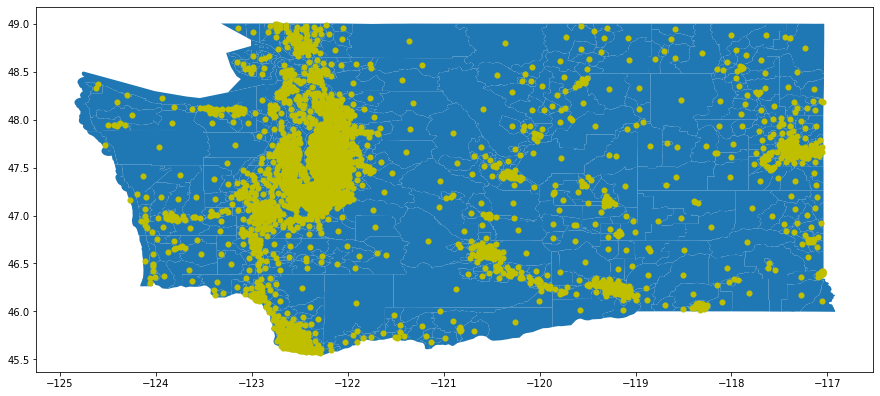

In [437]:
# join and plot coverage
bg_mapped = pd.concat([bg_within, bg_intersects, bg_g_left1, bg_c_left1]).set_geometry('geometry')

ax = bg_mapped.plot(figsize=(15,15))
bg_mapped.set_geometry('centroid').plot(color='y', linewidth=0.1, ax=ax)

In [438]:
# coverage
print('geometry within: {0}'.format(bg_within.shape[0]/bg.shape[0]))
print('centroid within: {0}'.format(bg_intersects.shape[0]/bg.shape[0]))
print('geometry intersects 1 ZCTA: {0}'.format(bg_g_left1.shape[0]/bg.shape[0]))
print('geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: {0}'.format(bg_c_left1.shape[0]/bg.shape[0]))
print('total coverage: {0}'.format(bg_mapped.GEOID.isin(bg.GEOID).sum()/bg.GEOID.nunique()))


geometry within: 0.6725904244198202
centroid within: 0.3180012544428183
geometry intersects 1 ZCTA: 0.0029270332427346855
geometry intersects multiple ZCTA, centroid intersects 0 ZCTA: 0.006481287894626803
total coverage: 1.0


In [440]:
# export to shapefiles
bg_mapped.drop('centroid', axis=1).to_file('Census_bg_zcta_53.shp')

In [441]:
# export to dataframe
bg_mapped.drop(['geometry','centroid'], axis=1).to_csv('Census_bg_zcta_53.csv', header=True, index=False)